# Circuit Partitioning Walkthrough

This is a brief intro to the contents of the repository, showing a basic workflow for partitioning a quantum circuit across multiple QPUs.

The partitioning has a number of phases, some of which can be modified or removed in a modular fashion.

Typically we have the phases:

1. Transpilation

The circuit is transpiled into a particular gate set. The framework is currently only compatible with the $[ U(\theta, \phi, \lambda), CP(\theta)]$ gateset, which is used by default.

2. Graph conversion

The circuit is converted into the "GCP hypergraph" framework

3. Coarsening (optional) 

The graph is coarsened into a graph which is smaller and easier to optimise - this phase is often included in the partitioning.

4. Partitioning 

The coarse-grained graph is partitioned using the FM algorithm

5. Refinement

The graph is iteratively uncoarsened and refined using the FM algorithm

6. Circuit extraction

A quantum circuit is extracted, containing all the new information for qubit and gate teleportation


## Transpilation

We begin by defining a circuit and using the built in qiskit transpiler to put it into the (u,cp) gate-set.

In [2]:
from qiskit.circuit.library import QFT
from MLFM_GCP.circuits.cp_fraction import cp_fraction
from qiskit import transpile

num_qubits = 12 # Define the number of qubits

num_partitions = 2 # Define the number of partitions or QPUs you will distribute over

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_info = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create the circuit
circuit = cp_fraction(num_qubits, depth = 2*num_qubits, fraction = 0.5)

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)


print(circuit.depth())

24


# Graph conversion

We now convert the circuit to the GCP Hypergraph using a number of predefined functions which can be found in the src code.

There is an optional parameter in the 'map_circuit_to_hypergraph' function called 'group_gates'. If this is set to false, then we get a regular graph with state edges connecting qubit nodes at successive time steps, and state edges for each two-qubit gate. If group_gates is set to true, then a pass is applied which merges some of these gate edges into hyper-edges. This makes the graph structure a bit more complex, so avoid it for now. We can tackle that later.

We will also set the 'assignment' which is our problem variable. It's a matrix of dimension $depth \times num\_qubits$. Assignment[t][q] indicates the partition qubit $q$ is assigned to at time $t$. This corresponds to node $(q,t)$. The initial assignment just maps qubits in a greedy fashion, squeezing qubits onto the first QPU until its full then moving to the next. The assignment at $t=0$ is then used for the full depth.

In [3]:
from MLFM_GCP.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from MLFM_GCP.partitioning.FM.FM_methods import set_initial_partitions

depth = circuit.depth() # Get the depth of the circuit

graph = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=False, map_circuit=True)


assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

print(assignment)

[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]


If you want to look at the graph, you can use the following code to draw it. It's just something that's been thrown together so doesn't work very well and you have to play around with the scale but it can be useful to see what's going on.

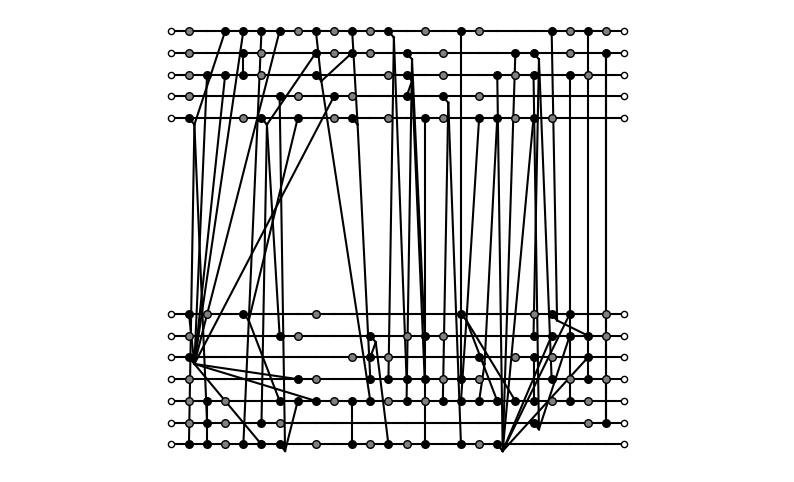

In [4]:
from MLFM_GCP.drawing.mpl_drawing import hypergraph_to_matplotlib

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

The next few steps are all wrapped up in the optimisation routine. I will add more to show what's going on under the hood but for now I'll just show how to generate the result.

## Partitioning

I will just include the standard Fiduccia-Mattheyses heuristic here, which doesn't do any coarsening. Don't worry about all the kwargs and parameters too much. The final cost will be the entanglement cost, the final assignment is the optimised mapping of nodes to partitions (qubits to QPUs at each t) and the cost list is just the cost after each pass of the algorithm which is used for benchmarking,

In [5]:
from MLFM_GCP.partitioning.FM.FM_main import run_FM

node_counts = len(graph.nodes)

move_limit = node_counts * 0.125

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_info,
    num_partitions,
    limit=move_limit,
    max_gain=4,
    passes=100,
    stochastic=True,
    active_nodes=graph.nodes,
    log=False,
    add_initial=False,
    costs=None
)

print(f'Final cost: {final_cost}')


Final cost: 13


If you want you can use the drawing tool to see what the new solution looks like, where the nodes are dragged around to match the assignment. The assignment variable will have to be replaced with final_assignment now! If it's working properly you should see two (or however many partitions you have) sub-graphs which are connected only by the non-local/cutting edges. You can count them to make sure it corresponds to the final cost (although this gets messy for big graphs and when hyper-edge are introduced)

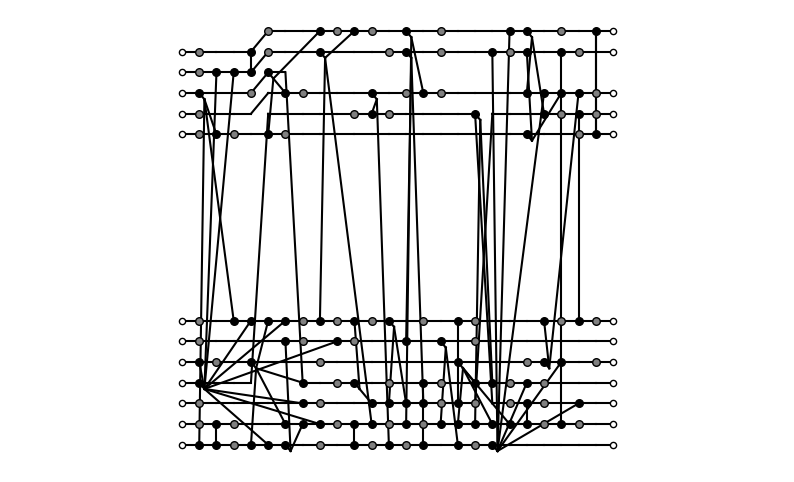

In [6]:
mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    final_assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

Below is just an example of a mutli-level algorithm which has used a coarsening routine. You can see that the solution should be better and the figure should look a bit cleaner too.

In [7]:
from MLFM_GCP.partitioning.FM.multilevel_FM import MLFM_recursive

move_limit = num_qubits

assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit=move_limit, 
                                        pass_list=None, 
                                        stochastic=True, 
                                        lock_nodes=True,
                                        log=True,
                                        add_initial=False,
                                        costs=None)


print(f'Final cost: {min(cost_list)}')

final_assignment = assignment_list[cost_list.index(min(cost_list))]

Initial cost: 23
All passes complete.
Final cost: 12
Best cost at level 0: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 1: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 2: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 3: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 4: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 5: 12
Final cost: 12


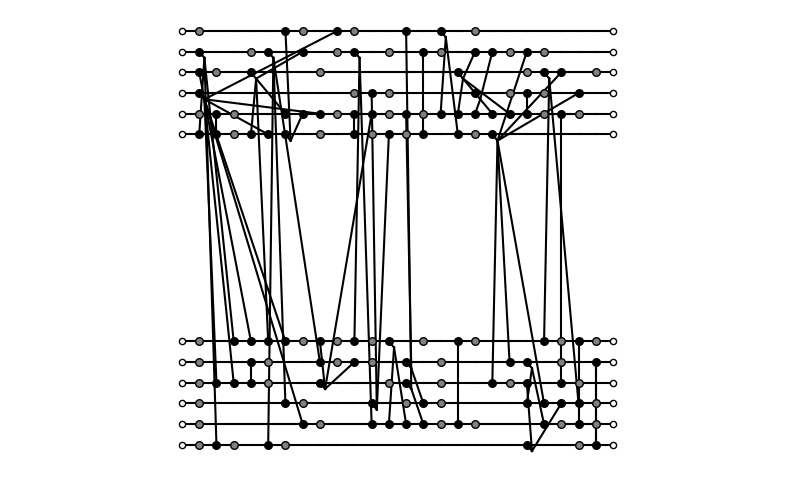

In [8]:
mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    final_assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

# Circuit extraction



In [9]:
from MLFM_GCP.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        partition_assignment=final_assignment, 
                                        qpu_info=qpu_info, 
                                        comm_info=[2]*num_partitions)

final_circuit = extractor.extract_partitioned_circuit()

UnboundLocalError: cannot access local variable 'linked_root' where it is not associated with a value

/Users/ftb123/MLQCP_FM/.venv/lib/python3.13/site-packages/qiskit/circuit/quantumcircuit.py:3394: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


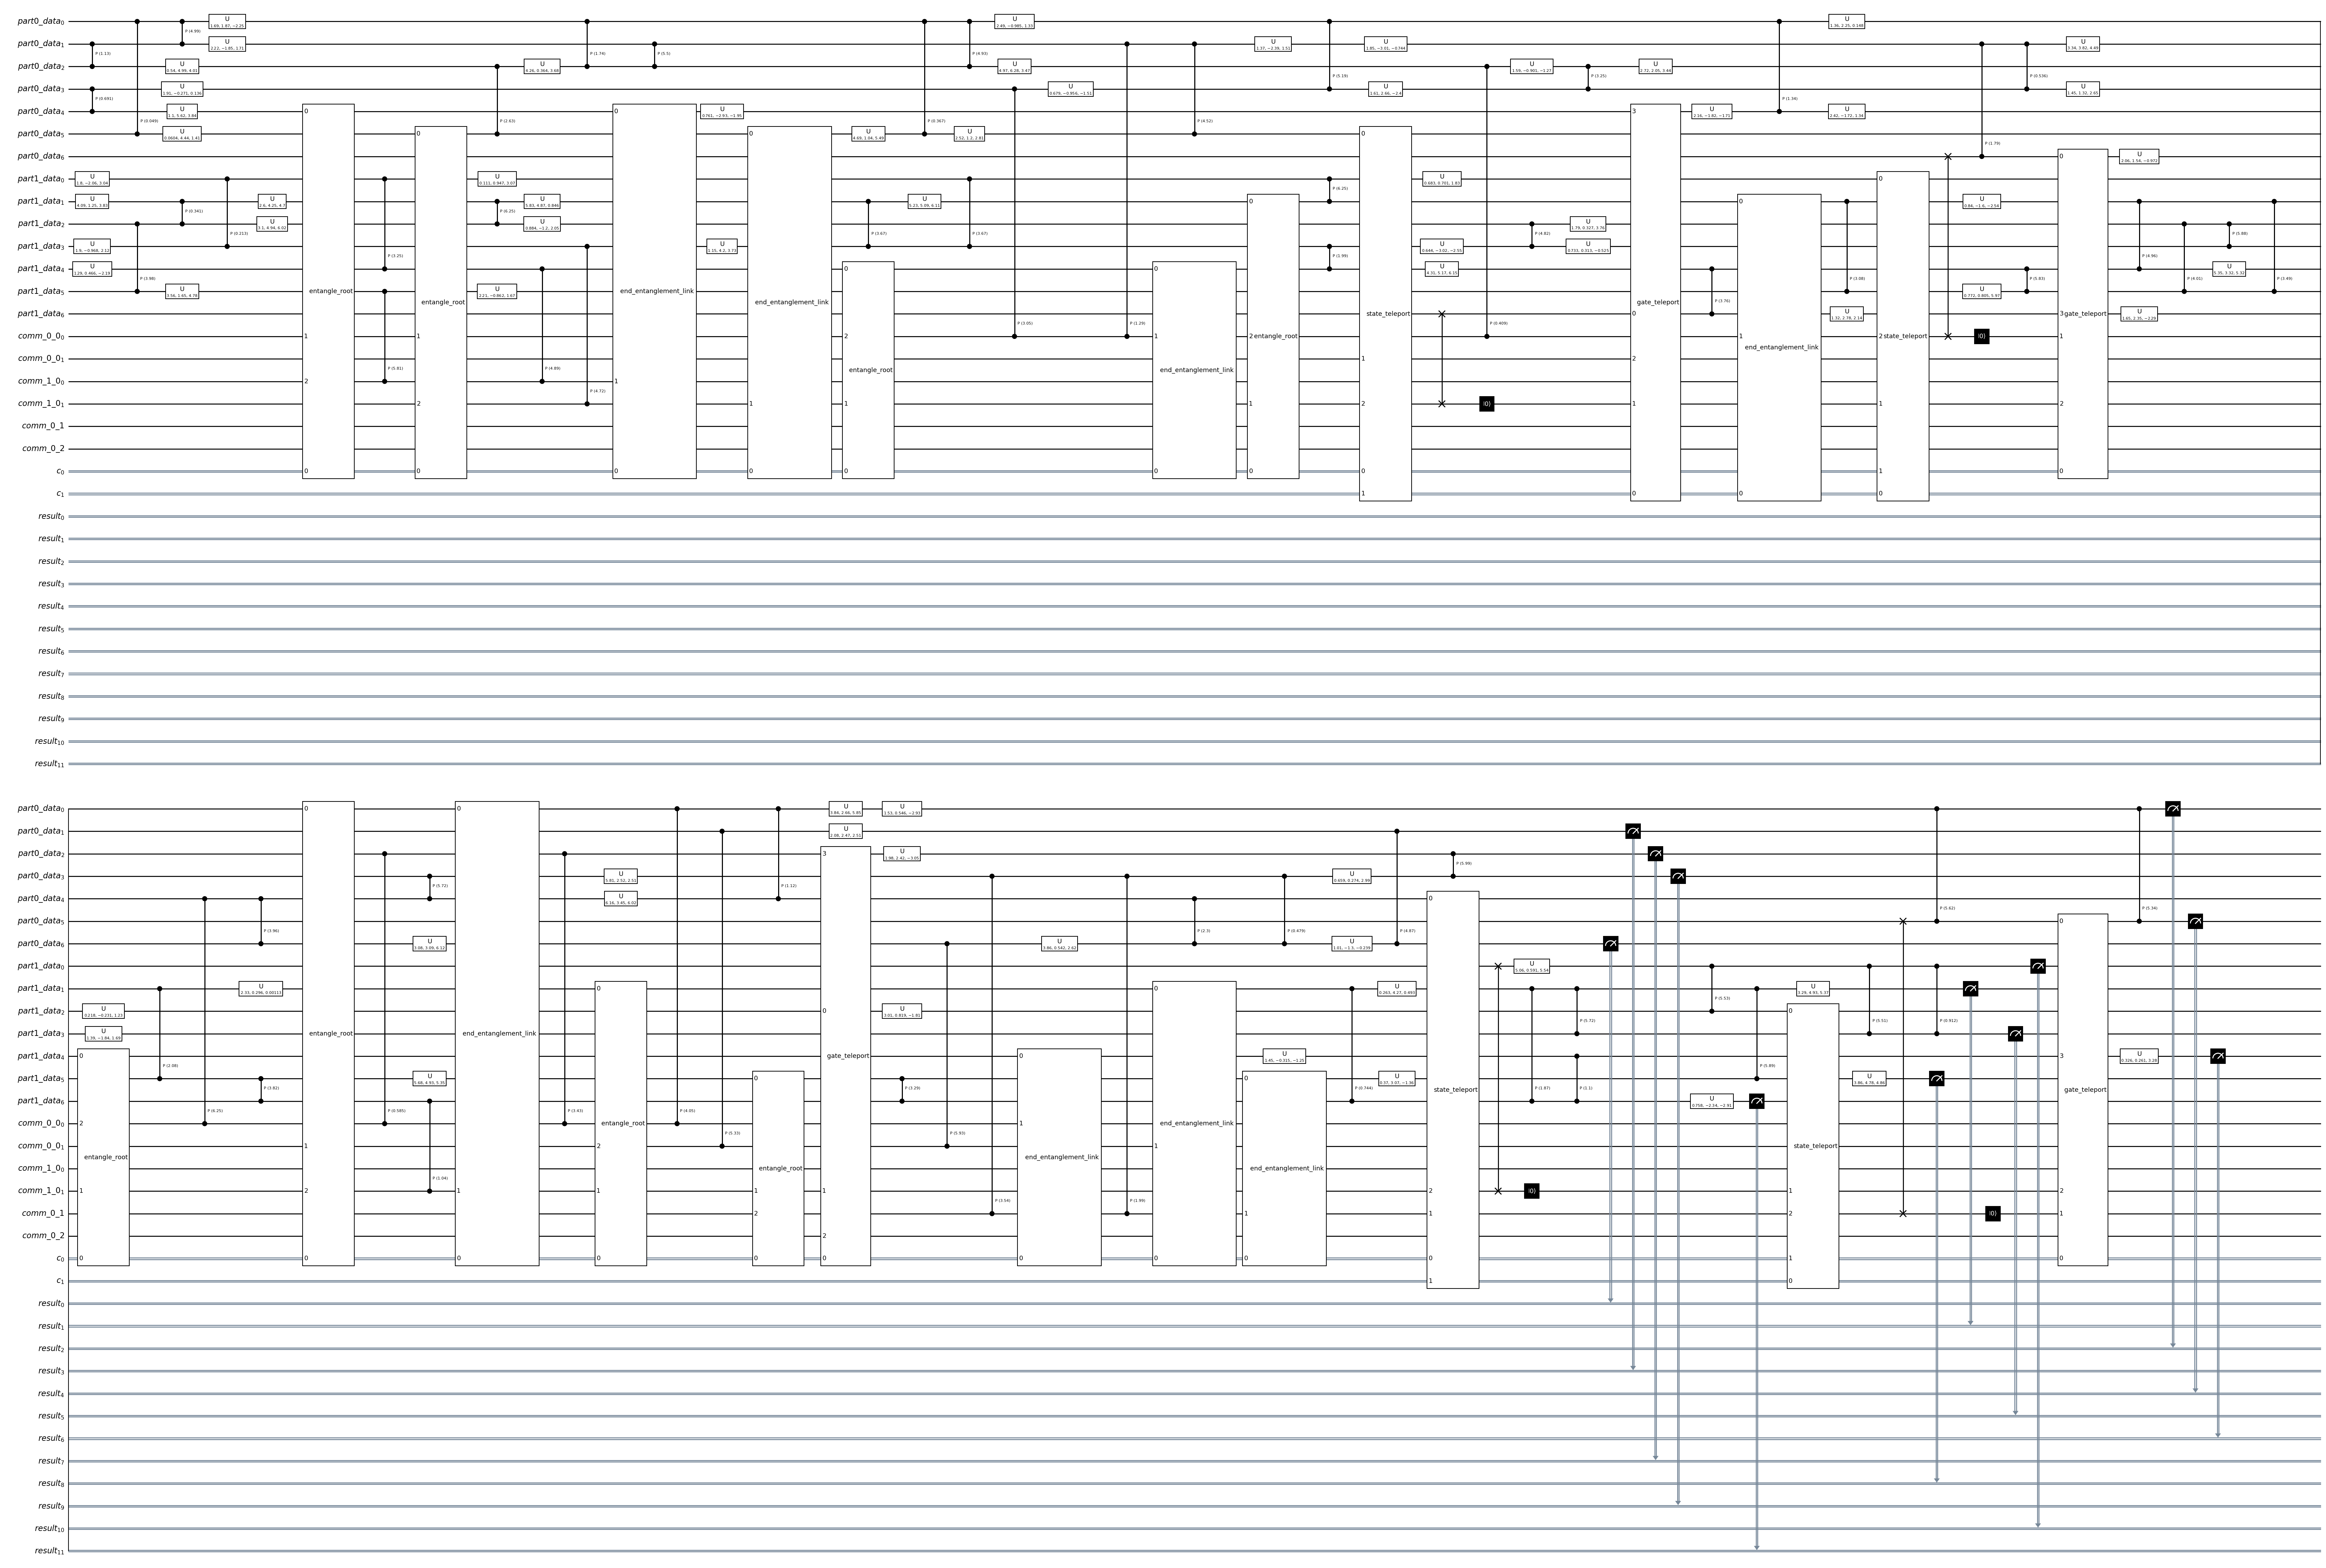

In [ ]:
final_circuit.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit

[]

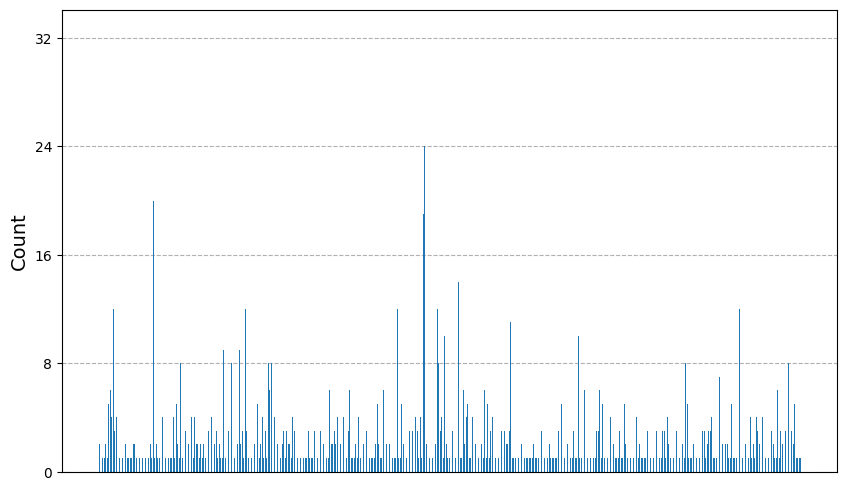

In [ ]:
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister

measured_circuit = circuit.copy()
measured_circuit.measure_all()


sampler = SamplerV2()

job = sampler.run([measured_circuit], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_base = data['meas'].get_counts()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_histogram(counts_base, bar_labels=False, ax=ax)
ax.set_xticks([])

[]

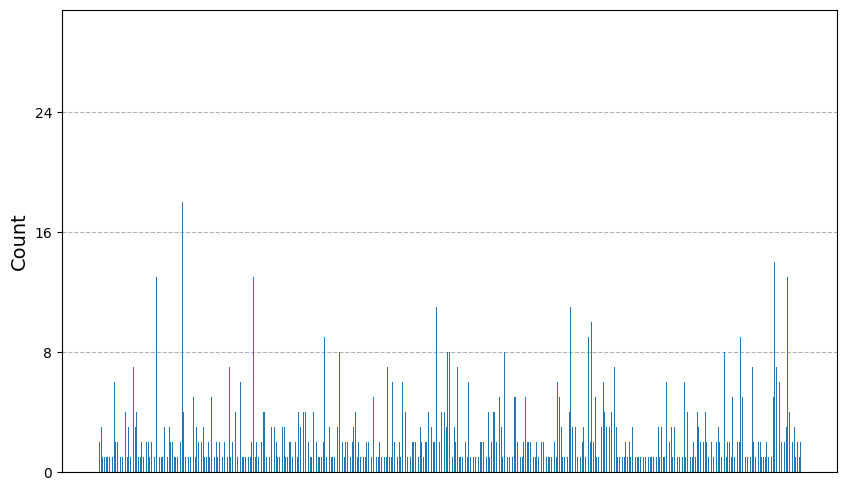

In [ ]:
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister

final_circuit_tr = transpile(final_circuit, basis_gates=['u', 'cp', 'EPR'])

final_circuit_dec = final_circuit_tr.decompose()


sampler = SamplerV2()

job = sampler.run([measured_circuit], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_base = data['meas'].get_counts()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_histogram(counts_base, bar_labels=False, ax=ax)
ax.set_xticks([])

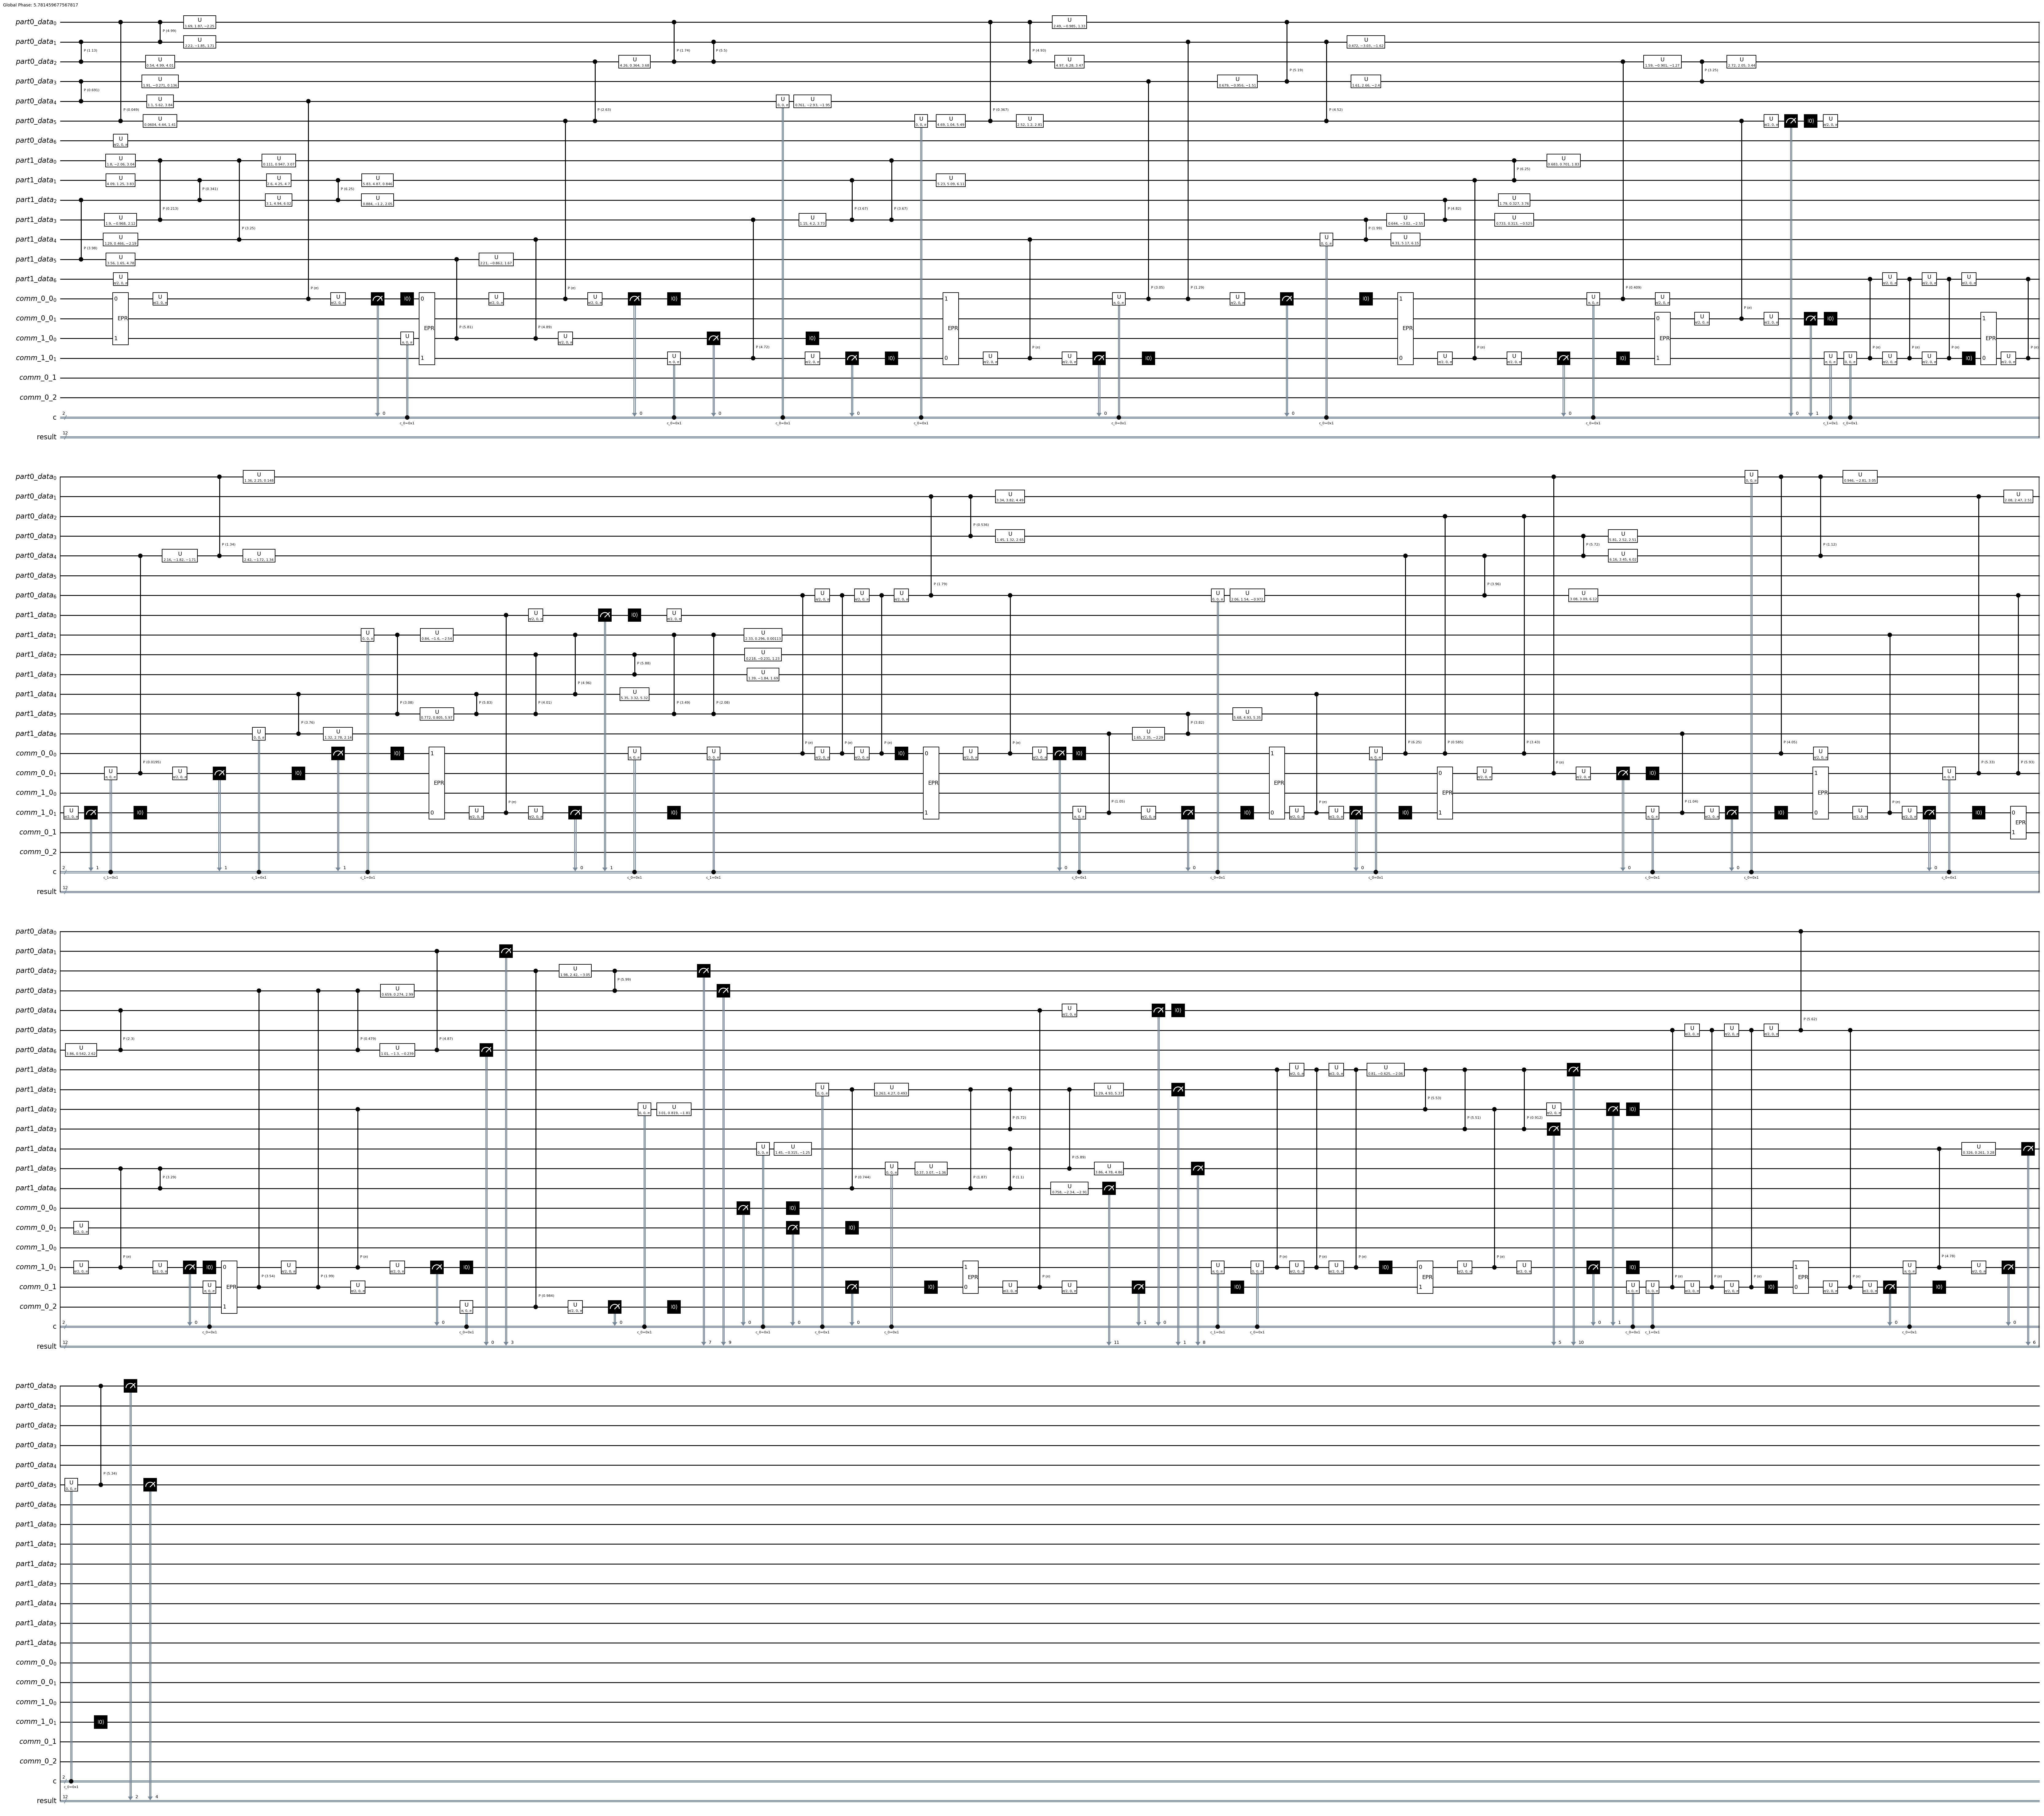

In [ ]:
final_circuit_tr.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit

See circuit extraction notebook for more!